In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import ferel
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Generate toy data sampled uniformly from a cube.
X, y, normal, b = ferel.toy_data_generation.gen_toy_data_uniform(
    n_samples=5000, n_str_rel=1, n_weak_rel=2, n_irrel=2)

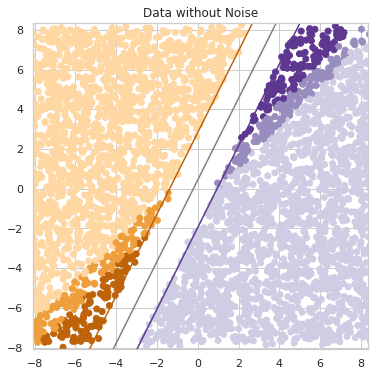

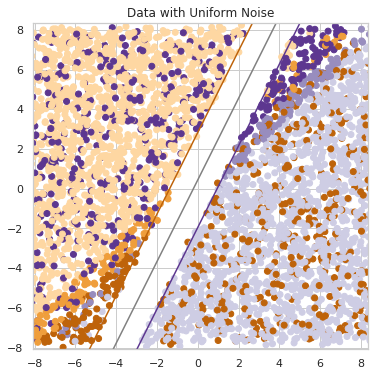

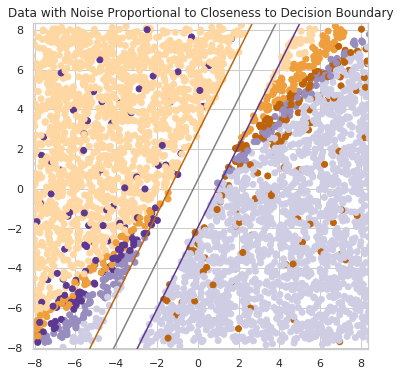

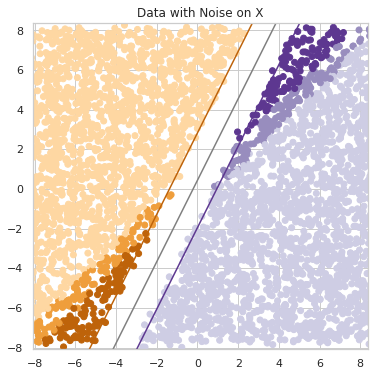

In [10]:
# Plot toy data using one of our special plotting functions.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, normal, b)
ax.set_title('Data without Noise')

y_with_noise_1 = ferel.toy_data_generation.add_label_noise_uniform(y, 0.2)
ax = ferel.plotting.scatter_2d_hyperplane(X, y_with_noise_1, 0, 1, normal, b)
ax.set_title('Data with Uniform Noise')

y_with_noise_2 = ferel.toy_data_generation.add_label_noise_border(X, y, normal, b, 0.2)
ax = ferel.plotting.scatter_2d_hyperplane(X, y_with_noise_2, 0, 1, normal, b)
ax.set_title('Data with Noise Proportional to Closeness to Decision Boundary');

X = ferel.toy_data_generation.add_data_noise_gaussian(X, 0.1)
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, normal, b)
ax.set_title('Data with Noise on X');

In [11]:
# Perform a z-score transformation on the data ( X_scaled = (X - mean(X))/std(X) )
X = X - np.mean(X)
scaling = np.std(X,0)
X = X / scaling
normal = normal * scaling

Text(0.5, 1.0, 'z-score transformed data')

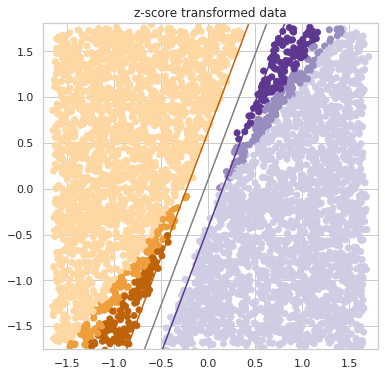

In [12]:
# Plot again.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, normal, b)
ax.set_title('z-score transformed data')

In [36]:
import cvxpy as cvx
def find_hyp_l1(X, y, X_test, y_test, random_state=None):
    """
    Determine a separating hyperplane using L1-regularization
    """
    # Prepare variables.
    (n, d) = X.shape
    print('(n,d): ' + str((n,d)))
    w = cvx.Variable((d, 1))
    b = cvx.Variable()
    
    # Prepare problem.
    loss = cvx.sum(cvx.pos(1 - cvx.multiply(y, X * w - b)))
    reg = cvx.norm(w, 1)
    C = cvx.Parameter(nonneg=True)
    prob = cvx.Problem(cvx.Minimize((loss / n) + C * reg))
    
    # Compute a trade-off curve and record train and test error.
    TRIALS = 100
    TEST = X_test.shape[0]
    train_error = np.zeros(TRIALS)
    test_error = np.zeros(TRIALS)
    C_vals = np.logspace(-2, 0, TRIALS)
    w_vals = []
    for i in range(TRIALS):
        C.value = C_vals[i]
        print('Reg parameter: ' + str(C_vals[i]))
        prob.solve(verbose=True)
        train_error[i] = (y != np.sign(X.dot(w.value) - b.value)).sum()/n
        test_error[i] = (y_test != np.sign(X_test.dot(w.value) - b.value)).sum()/TEST
        w_vals.append(w.value)
    return w_vals, C_vals, train_error, test_error

In [37]:
m = 1000
from sklearn.model_selection import train_test_split
y = y.reshape((5000, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(y.shape)
print(y_train.shape)
w_vals, lambda_vals, train_error, test_error = find_hyp_l1(X_train, y_train, X_test, y_test)

(5000, 1)
(3350, 1)
(n,d): (3350, 5)
Reg parameter: 0.01
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 3362, constraints m = 6711
          nnz(P) + nnz(A) = 26826
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -9.9335e-01   1.60e+01   2.36e+00   1.00e-01   5.91e-03s
 200   5.9685e-02   2.33e-02   7.41e-04   1.41e

2600   6.4577e-02   3.35e-03   6.13e-06   2.61e-03   4.69e-01s
2800   6.4585e-02   3.25e-03   1.76e-06   2.61e-03   5.01e-01s
3000   6.4578e-02   3.07e-03   2.41e-06   2.61e-03   5.34e-01s
3200   6.4576e-02   2.22e-03   3.22e-06   2.61e-03   5.66e-01s
3400   6.4579e-02   2.15e-03   2.17e-06   2.61e-03   5.99e-01s
3600   6.4576e-02   2.59e-03   1.57e-06   2.61e-03   6.35e-01s
3800   6.4574e-02   1.74e-03   2.39e-06   2.61e-03   6.76e-01s
4000   6.4576e-02   1.60e-03   2.02e-06   2.61e-03   7.17e-01s
4200   6.4571e-02   2.30e-03   1.47e-06   2.61e-03   7.57e-01s
4400   6.4573e-02   2.35e-03   2.12e-06   2.61e-03   7.97e-01s
4600   6.4576e-02   1.83e-03   1.06e-06   2.61e-03   8.40e-01s
4800   6.4572e-02   1.78e-03   1.03e-06   2.61e-03   8.71e-01s
5000   6.4576e-02   1.50e-03   3.00e-06   2.61e-03   9.03e-01s
5200   6.4572e-02   1.30e-03   3.34e-06   2.61e-03   9.35e-01s
5400   6.4568e-02   9.36e-04   3.17e-06   2.61e-03   9.71e-01s
5600   6.4569e-02   1.33e-03   1.18e-06   2.61e-03   1.

8000   6.9744e-02   9.05e-04   1.10e-06   2.61e-03   1.37e+00s
8200   6.9741e-02   1.11e-03   3.61e-07   2.61e-03   1.41e+00s
8400   6.9744e-02   7.10e-04   1.38e-06   2.61e-03   1.44e+00s
8600   6.9750e-02   7.58e-04   1.02e-06   2.61e-03   1.47e+00s
8800   6.9745e-02   6.92e-04   1.17e-06   2.61e-03   1.51e+00s
9000   6.9744e-02   8.35e-04   1.21e-06   2.61e-03   1.54e+00s
9200   6.9748e-02   6.58e-04   1.23e-06   2.61e-03   1.58e+00s
9400   6.9747e-02   9.11e-04   9.74e-07   2.61e-03   1.61e+00s
9600   6.9746e-02   8.57e-04   1.01e-06   2.61e-03   1.65e+00s
9800   6.9746e-02   1.06e-03   6.48e-07   2.61e-03   1.68e+00s
10000   6.9746e-02   7.03e-04   9.72e-07   2.61e-03   1.71e+00s

status:               solved inaccurate
number of iterations: 10000
optimal objective:    0.0697
run time:             1.72e+00s
optimal rho estimate: 3.32e-03

Reg parameter: 0.012618568830660204
iter   objective    pri res    dua res    rho        time
   1  -1.4781e+00   3.51e+01   3.43e-04   2.61e-03

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [35]:
print(y)

[[-1.]
 [ 1.]
 [-1.]
 ...
 [-1.]
 [ 1.]
 [ 1.]]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

In [ ]:
# Plot the regularization path for beta.
for i in range(n):
    plt.plot(lambda_vals, [wi[i,0] for wi in w_vals])
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")

In [15]:
C = 1
hyp, offset, slack, C = ferel.ferel.find_hyp_l1(X, y, C=C)

# Plot data together with the determined separating hyperplane.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, hyp, offset)
ax.set_title('Data with Separating Hyperplane');

print(hyp / np.linalg.norm(hyp))


from sklearn import svm
clf = svm.LinearSVC(penalty='l1', C=C, loss='squared_hinge', dual=False)
clf.fit(X, y)
hyp2 = np.ndarray.flatten(clf.coef_.T)
offset2 = - clf.intercept_

print(hyp2 / np.linalg.norm(hyp2))

ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, hyp2, offset2)
ax.set_title('Data with Separating Hyperplane');

(n,d): (5000, 5)
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 5011, constraints m = 10010
          nnz(P) + nnz(A) = 40020
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -7.2738e+04   2.18e+01   6.40e+02   1.00e-01   1.05e-02s
 200   1.0319e+01   5.44e-01   8.95e-01   3.20e-03   6.67e-02s
 400   1.0590e+01   2.4

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
print(type(hyp), hyp.shape, type(hyp2), hyp2.shape)

In [ ]:
type(slack)

In [ ]:
# Find seperating hyperplane.
hyp2, offset2, slack2, acc, C = ferel.ferel.find_hyp_ridge(X, y, C=0.1)

# Plot data together with the determined separating hyperplane.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, hyp, offset)
ax.set_title('Data with Separating Hyperplane');

In [ ]:
# Investigate found separating hyperplane
print(
    'Found hyperplane has {} intrusions from label 1 and {} intrusions from label -1. \n \
Slack variable losses sum to {} and {}, respectively. \n \
The accuracy on the training data is {} with {} misclassifications.'.format(
        np.count_nonzero(y[np.logical_and(y == 1, slack > 0)]),
        np.count_nonzero(y[np.logical_and(y == -1, slack > 0)]),
        np.sum(slack[y == 1]),
        np.sum(slack[y == -1]), acc, np.count_nonzero(slack[slack > 1])))

In [ ]:
# Calculate relevance bounds.
omega, xp, b = ferel.ferel.find_relevances(X, y, hyp, offset, slack, C)

# Plot the hyperplanes for dimension 1 found by the optimization problems.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, omega[:,0], b[0])
ax.set_title('Separating hyperplane that minimizes first component relevance')
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, omega[:,1], b[1])
ax.set_title('Separating hyperplane that maximizes first component relevance')

In [ ]:
n_iter = 5
(n, d) = X.shape
shadows = np.zeros((n_iter, 2 * d))

for i in range(n_iter):
    # Calculate shadow relevance bounds
    shadows[i, :] = ferel.ferel.find_shadow_relevances(X, y, hyp, offset, slack, C)
print('Over {} iterations, found mean shadow relevance vector \n{}\n with std \n{}.'.
      format(n_iter, np.mean(shadows, 0), np.std(shadows,0)))

# Correct relevances by those found by shadow features
xp[1::2] = np.maximum(0, xp[1::2] - np.mean(shadows, 0)[1::2])
# Set extremely small relevances values to zero
eps = 1e-10
xp[xp < eps] = 0

In [ ]:
stacked = np.transpose(np.vstack((xp[1::2], xp[0::2])))
# Visualize feature relevances
ax = ferel.plotting.plot_intervals(stacked)